In [1]:
### Hide the input codes   ###
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


# UnifiedDataLayers
*Author: Sina Kashuk*

### Summary: 
One of the applications of hexagons is to be able to combine different datasets with different geographic shapes and forms. In this tutorial we are going through an example of how to bring the US census data, NYC 311 Noise complaints, and Digital Elevation Model to the hexagon aperture and then how to visualize the data to gain insight.

### Data
* **POLYGON:** Census Tract Data [[Source]](https://www.census.gov/data.html)
* **POINT:** NYC 311 noise complaints [[Source]](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/7ahn-ypff)
* **RASTER:** NYC Digital Elevation Model [[Source]](https://data.cityofnewyork.us/City-Government/1-foot-Digital-Elevation-Model-DEM-Integer-Raster/7kuu-zah7/)

In [2]:
# modified data link
ct_data_link = 'https://gist.githubusercontent.com/kashuk/e6e3e3d8fde34da1212b59248a7cc5a8/raw/da3b63c1c0ef4a1c8cc8e10f61455c436a0d0ad9/CT_data.csv'
ct_shape_link = 'https://gist.githubusercontent.com/kashuk/d73342adeccbc65de7a53e19ad78b4df/raw/4300dcb80861d454ecae8f8429166e196779fc21/CT_simplified_shape.json'
noise_311_link = 'https://gist.githubusercontent.com/kashuk/670a350ea1f9fc543c3f6916ab392f62/raw/4c5ced45cc94d5b00e3699dd211ad7125ee6c4d3/NYC311_noise.csv'
nyc_dem_link = 'https://gist.githubusercontent.com/kashuk/a08dc8f65b1b1aebafdcab9c0eda3346/raw/4d1cf7a306327f3570ddd6e4979e568ee82c2c71/dem_nyc_encoded.tif'

### Import & Functions

In [69]:
# import
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import shapely
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import mapping
from shapely.ops import cascaded_union#, unary_union
import numpy as np
import h3
import base64
import urllib
import tempfile
import matplotlib.pyplot as plt
base = gpd.read_file('./Dist/TOWN_MOI_1091016.shp', encoding='utf-8')
TPE = base[base["COUNTYNAME"] == "臺北市"]
TPE['coords'] = TPE['geometry'].apply(lambda x: x.representative_point().coords[:])
TPE['coords'] = [coords[0] for coords in TPE.loc[:, 'coords']]
TPE["TOWNENG"] = TPE["TOWNENG"].apply(lambda x: x[:-8])
boundary = cascaded_union(TPE.geometry)
%matplotlib inline

#Functions
def plot_hex(df, metric_col, name="default", alpha=1, figsize=(16,16), colormap='Reds'):    
    fig, ax = plt.subplots(1,figsize=figsize)
    TPE.plot(ax=ax, facecolor="none", edgecolor="navy", lw=3)
    for idx, row in TPE.iterrows():
        plt.annotate(s=row['TOWNENG'], xy=row['coords'], horizontalalignment='center', color='black', fontsize=9)
    print(type(df))
    df.plot(ax=ax, column=metric_col, colormap=colormap, alpha=alpha, legend=True)
    plt.xticks([], []); plt.yticks([], [])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
#     fig.savefig(f"./plots/.{name}png")

def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,16), colormap='viridis', edgecolor="none"):    
    fig, ax = plt.subplots(1,figsize=figsize)
    TPE.plot(ax=ax, facecolor="none", edgecolor="navy", lw=3)
    for idx, row in TPE.iterrows():
        plt.annotate(s=row['TOWNENG'], xy=row['coords'], horizontalalignment='center', color='black', fontsize=9)
    df.plot.scatter(ax=ax, x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors=edgecolor, colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])

def aperture_downsampling(df, hex_col, metric_col, coarse_aperture_size):
    df_coarse = df.copy()
    coarse_hex_col = 'hex{}'.format(coarse_aperture_size)
    df_coarse[coarse_hex_col] = df_coarse[hex_col].apply(lambda x: h3.h3_to_parent(x,coarse_aperture_size))
    dfc = df_coarse.groupby([coarse_hex_col])[[metric_col,]].mean().reset_index()
    dfc['lat'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfc['lng'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfc

def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

def weighted_kring_smoothing(df, hex_col, metric_col, coef):
    # normalize the coef
    a = []
    for k, coe in enumerate(coef):
        if k == 0:
            a.append(coe)
        else:
            a.append(k * 6 * coe)
    coef = [c / sum(a) for c in coef]
    
    # weighted smoothing 
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col,inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0
    K=len(coef)-1 
    for k in range(1,K+1):
        temp2.append((df_agg['hexk']
                     .apply(lambda x: pd.Series(list(h3.hex_ring(x,k)))).stack()
                     .to_frame('hexk').reset_index(1, drop=True).reset_index()
                ))
        temp2[-1]['k'] = k
    df_all = pd.concat(temp2).merge(df)
    df_all[metric_col] = df_all[metric_col]*df_all.k.apply(lambda x:coef[x])
    dfs = df_all.groupby('hexk')[[metric_col]].sum().reset_index().rename(index=str, columns={"hexk": hex_col})
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs

    TOWNID  TOWNCODE COUNTYNAME TOWNNAME              TOWNENG COUNTYID  \
150    A02  63000030        臺北市      大安區       Da'an District        A   
151    A11  63000080        臺北市      文山區     Wenshan District        A   
332    A17  63000020        臺北市      信義區       Xinyi District        A   
333    A05  63000070        臺北市      萬華區      Wanhua District        A   
334    A03  63000050        臺北市      中正區  Zhongzheng District        A   
335    A13  63000090        臺北市      南港區     Nangang District        A   
336    A01  63000010        臺北市      松山區    Songshan District        A   
337    A09  63000060        臺北市      大同區      Datong District        A   
338    A10  63000040        臺北市      中山區   Zhongshan District        A   
339    A14  63000100        臺北市      內湖區       Neihu District        A   
340    A15  63000110        臺北市      士林區      Shilin District        A   
341    A16  63000120        臺北市      北投區      Beitou District        A   

    COUNTYCODE                       

## Point to Hex

### Load 311 Noise Complaints

In [38]:
# load the 311 noise complaints 
df311 = pd.read_csv(noise_311_link)

# Visualize the 311 noise complaints points
df311.plot(x='lng',y='lat',style='.',alpha=1,figsize=(12,12));
plt.title('sample points: 311 noise compliants');

NameError: name 'noise_311_link' is not defined

### 311 Point to Hex

In [39]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
df311[hex_col] = df311.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)

# aggregate the points
df311g = df311.groupby(hex_col).size().to_frame('cnt').reset_index()

#find center of hex for visualization
df311g['lat'] = df311g[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df311g['lng'] = df311g[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# pltot the hexs
plot_scatter(df311g, metric_col='cnt', marker='o',figsize=(17,15))
plt.title('hex-grid: noise complaints');

NameError: name 'df311' is not defined

### Spatial Smoothing

In [40]:
#kring_smoothing
k = 2
df311s= kring_smoothing(df311g, hex_col, metric_col='cnt', k=k)
print('sum sanity check:', df311s['cnt'].sum() / df311g['cnt'].sum())
plot_scatter(df311s, metric_col='cnt', marker='o')
plt.title('noise complaints: 2-ring average');

NameError: name 'df311g' is not defined

## Polygon to Hex

### Load Census Tract Data

In [41]:
METRIC_COL = 'SE_T002_002' #population density

# Load Census Tract (CT) ShapeFile
gdf=GeoDataFrame.from_file(ct_shape_link)
gdf['gdf'] = gdf['BoroCT2010'].astype(str) 

# Load CT Data & Join w/ ShapeFile
df = pd.read_csv(ct_data_link, usecols=['BoroCT2010',METRIC_COL])
df['BoroCT2010'] = df['BoroCT2010'].astype(str)

# join metadata
gdf = df.merge(gdf).fillna(0)
gdf.crs = {"init": "epsg:4326"}
gdf.sample(3)

# Visualize Population Density per Census Tract
f, ax = plt.subplots(figsize=(12,12)); 
ax.get_xaxis().set_visible(False); 
ax.get_yaxis().set_visible(False)
GeoDataFrame(gdf).plot(column=METRIC_COL,colormap='viridis',alpha=1,linewidth=0.05,ax=ax)
plt.title('census tract: population density');

NameError: name 'ct_shape_link' is not defined

### Census Polygon to Hex 

In [42]:
APERTURE_SIZE = 10 
# Unify the CT boundries
union_poly = cascaded_union(gdf.geometry)

# Find the hexs within the city boundary using PolyFill
hex_list=[]
for n,g in enumerate(union_poly):
    print(n,'\r')
    temp  = mapping(g)
    temp['coordinates']=[[[j[1],j[0]] for j in i] for i in temp['coordinates']]  
    hex_list.extend(h3.polyfill(temp,APERTURE_SIZE))

# create hex dataframe
hex_col = 'hex{}'.format(APERTURE_SIZE)
dfh = pd.DataFrame(hex_list,columns=[hex_col])
print('Sanity Check\nnumber of hexes:', len(hex_list))
print('number of duplicates:', len(hex_list) - len(dfh.drop_duplicates()))

# add lat & lng of center of hex 
dfh['lat']=dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
dfh['lng']=dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# create Point object based on hex latlng
dfh['geometry'] = dfh.apply(lambda x: shapely.geometry.Point(x.lng,x.lat),1)
dfh.crs = {"init": "epsg:4326"}

# plot hex latlng
dfh.plot(x='lng',y='lat',style='.',alpha=.1,figsize=(12,12));
plt.title('hex-grid: nyc')
# Intersect Hex Point with CT Polygon
df_ct = geopandas.tools.sjoin(gdf, dfh, how="inner")
df_ct.sample(3)

# Visualize Hexagons
plot_scatter(df_ct, metric_col=METRIC_COL, marker='.')
plt.title('hex-grid: population density');

0 


TypeError: 'float' object is not iterable

### Spatial Weighted Smoothing

NameError: name 'df_ct' is not defined

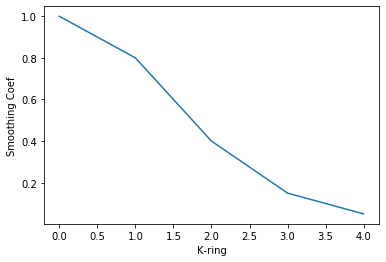

In [43]:
# kring smoothing coefficients
coef = [1, .8, .4, .15, 0.05]
plt.plot(coef)
plt.xlabel('K-ring')
plt.ylabel('Smoothing Coef')

# weighted kring smoothing
df_ct_kw = weighted_kring_smoothing(df_ct, hex_col, metric_col=METRIC_COL, coef=coef)
print('sum sanity check:', df_ct_kw[METRIC_COL].sum() / df_ct[METRIC_COL].sum())
plot_scatter(df_ct_kw, metric_col=METRIC_COL, marker='.')
plt.title('hex-grid: smoothed population density');

### Spatial Hierarchical 

In [44]:
# Spatial Hierarchy using h3_to_parent
coarse_aperture_size = 9
df_coarse = aperture_downsampling(df_ct_kw, hex_col, metric_col=METRIC_COL, coarse_aperture_size=coarse_aperture_size)
print('number of hex:', len(df_ct_kw))
print('number of coarse hex:', len(df_coarse))
plot_scatter(df_coarse, metric_col=METRIC_COL, marker='o')
plt.title('hex-grid: population density');

NameError: name 'df_ct_kw' is not defined

In [45]:
# Aperture 8
_ = aperture_downsampling(df_ct, hex_col, metric_col=METRIC_COL, coarse_aperture_size=8)
plot_scatter(_ , metric_col=METRIC_COL, marker='o',figsize=(8,6))
plt.title('hex-grid: population density');

NameError: name 'df_ct' is not defined

## Raster to Hex

### Load Digital Elevation Model Data

In [46]:
# create temp directory for GeoTiff file processing
temp_dir = tempfile.mkdtemp()

# download & decode GeoTiff data
open(temp_dir+'nyc_dem.tif', 'wb').write(base64.b64decode(urllib.urlopen(nyc_dem_link).read()))

# translate GeoTiff to XYZ points
!gdal_translate -of XYZ  $temp_dir'nyc_dem.tif' $temp_dir'nyc_dem.xyz'

# read xyz points
df = pd.read_csv(temp_dir+'nyc_dem.xyz',sep=' ',header=None,names=['lng','lat','elevation'])

# ignore the missing values
df = df[df.elevation>-1000]

# remove temp directory
!rm -r $temp_dir 

# Visualize the elevation
plot_scatter(df, metric_col='elevation', marker='.', colormap='gray')

AttributeError: module 'urllib' has no attribute 'urlopen'

### DEM Raster to Hex

In [47]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
df[hex_col] = df.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)

# calculate elevation average per hex
df_dem = df.groupby(hex_col)['elevation'].mean().to_frame('elevation').reset_index()

#find center of hex for visualization
df_dem['lat'] = df_dem[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df_dem['lng'] = df_dem[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# pltot the hexs
plot_scatter(df_dem, metric_col='elevation', marker='o')
plt.title('hex-grid: elevation');

NameError: name 'df' is not defined

# Unifying Data Layers

In [48]:
dfu = df_coarse[[METRIC_COL,hex_col]].merge(df311s[[hex_col,'cnt']]).merge(df_dem[[hex_col,'elevation']])
dfu.set_index(hex_col,inplace=True)
dfu.rename(index=str, columns={METRIC_COL: "population","cnt":"noise_complaints"},inplace=True)
dfu.population = dfu.population.clip_upper(dfu.population.quantile(.9))
dfu.noise_complaints = dfu.noise_complaints.clip_upper(dfu.noise_complaints.quantile(.9))
dfu.elevation = dfu.elevation.clip_upper(dfu.elevation.quantile(.9))
pd.scatter_matrix(dfu, alpha=0.05,figsize=(15,15));
# dfu['lat']=dfu['hex10'].apply(lambda x: h3.h3_to_geo(x)[0])
# dfu['lng']=dfu['hex10'].apply(lambda x: h3.h3_to_geo(x)[1])
dfu.describe()

NameError: name 'df_coarse' is not defined

# Hexagon Plots

In [49]:
# read file 
gdf = pd.read_pickle("./GeoData.p")
gdf = gdf.drop(columns=['rm'])
gdf

,geometry
0,POINT (121.53210 25.05200)
1,POINT (121.51050 25.05610)
2,POINT (121.53410 25.05870)
3,POINT (121.53300 25.03860)
4,POINT (121.52080 25.04440)
...,...
395,POINT (121.54700 25.03500)
396,POINT (121.53310 25.02170)
397,POINT (121.55310 25.02510)
398,POINT (121.55370 25.03430)


In [50]:
def get_hex(df, level = 9):
    hex_col = 'hex'+str(level)
    # find hexs containing the points
    df[hex_col] = df.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,level),1)
    # aggregate the points
    df = df.groupby(hex_col).size().to_frame('cnt').reset_index()
    #find center of hex for visualization
    df['lat'] = df[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    df['lng'] = df[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return df
    
def generate_random(number, polygon):
    import random
    from shapely.geometry import Point
    scatters = pd.DataFrame()
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    minx = (minx * 10000) % 100000
    maxx = (maxx * 10000) % 100000
    miny = (miny * 10000) % 100000
    maxy = (maxy * 10000) % 100000
    while len(points) < number:
        pnt = Point(120 + random.uniform(minx, maxx)/10000,20 + random.uniform(miny, maxy)/10000)
        if polygon.contains(pnt):
            points.append(pnt)
    scatters['geometry'] = points
    return scatters

In [51]:
scatters = generate_random(1000,boundary)
scatters

,geometry
0,POINT (121.547577968375 25.15243967387077)
1,POINT (121.5807582931566 25.10121673072463)
2,POINT (121.6100977126836 25.07209133034404)
3,POINT (121.5492926514688 25.155994889968)
4,POINT (121.5956401747378 25.09284494833959)
...,...
995,POINT (121.5691386290964 25.16182313368336)
996,POINT (121.5413866414656 24.99452408065827)
997,POINT (121.5751778303637 25.05117807695887)
998,POINT (121.601565890336 25.0714506183206)


In [52]:
gdf = pd.concat([gdf,scatters])
gdf = gpd.GeoDataFrame(gdf,geometry=gdf.geometry)
gdf["lat"] = gdf.geometry.apply(lambda x: x.coords[0][1])
gdf["lng"] = gdf.geometry.apply(lambda x: x.coords[0][0])

In [53]:
level=9
hex_col = 'hex'+str(level)
gdf_hex = get_hex(gdf, level)
gdf_hex

,hex9,cnt,lat,lng
0,894ba0a4003ffff,11,25.041169,121.517518
1,894ba0a4007ffff,5,25.042005,121.520743
2,894ba0a400bffff,13,25.038326,121.516431
3,894ba0a400fffff,11,25.039162,121.519656
4,894ba0a4013ffff,18,25.043176,121.515380
...,...,...,...,...
1221,894ba56b397ffff,1,25.178352,121.523540
1222,894ba56b3a3ffff,1,25.175184,121.531042
1223,894ba56b3a7ffff,1,25.176020,121.534269
1224,894ba56b3b3ffff,1,25.177186,121.528904


In [54]:
len(gdf)

8500

In [55]:
from shapely.ops import transform
from shapely.geometry import Polygon
def flip(x, y):
    return y, x
polys = []
lat = []
lng = []
for hex in gdf_hex[hex_col]:
    polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
    # flatten polygons into loops.
    outlines = [loop for polygon in polygons for loop in polygon]
    polyline = [outline + [outline[0]] for outline in outlines][0]
    lat.extend(map(lambda v:v[0],polyline))
    lng.extend(map(lambda v:v[1],polyline))
    polygon = transform(flip,Polygon(polygons[0][0]))
    polys.append(polygon)

print(len(polys), len(gdf_hex))
gdf_hex["geometry"] = polys
gdf_hex = gpd.GeoDataFrame(gdf_hex, geometry=gdf_hex["geometry"])
gdf_hex

1226 1226


,hex9,cnt,lat,lng,geometry
0,894ba0a4003ffff,11,25.041169,121.517518,"POLYGON ((121.51931 25.04078, 121.51896 25.042..."
1,894ba0a4007ffff,5,25.042005,121.520743,"POLYGON ((121.51931 25.04078, 121.52109 25.040..."
2,894ba0a400bffff,13,25.038326,121.516431,"POLYGON ((121.51787 25.03955, 121.51608 25.039..."
3,894ba0a400fffff,11,25.039162,121.519656,"POLYGON ((121.52109 25.04039, 121.51931 25.040..."
4,894ba0a4013ffff,18,25.043176,121.515380,"POLYGON ((121.51682 25.04440, 121.51503 25.044..."
...,...,...,...,...,...
1221,894ba56b397ffff,1,25.178352,121.523540,"POLYGON ((121.52498 25.17958, 121.52319 25.179..."
1222,894ba56b3a3ffff,1,25.175184,121.531042,"POLYGON ((121.52925 25.17557, 121.52960 25.173..."
1223,894ba56b3a7ffff,1,25.176020,121.534269,"POLYGON ((121.53606 25.17563, 121.53571 25.177..."
1224,894ba56b3b3ffff,1,25.177186,121.528904,"POLYGON ((121.52925 25.17557, 121.53069 25.176..."


<class 'geopandas.geodataframe.GeoDataFrame'>


Text(0.5, 1, 'hex9')

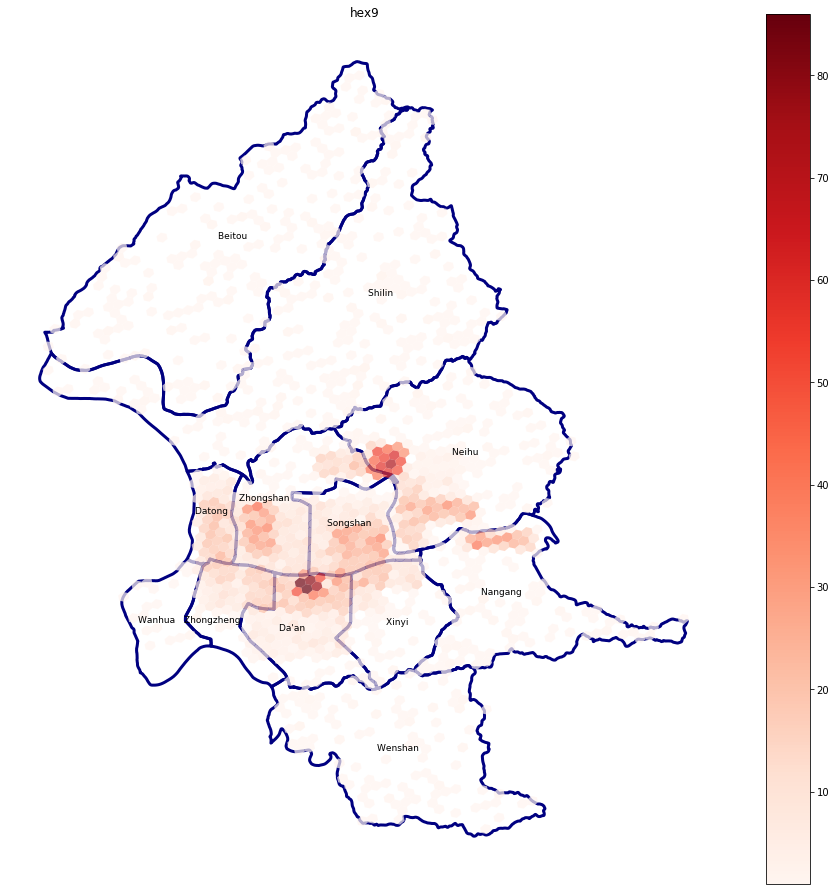

In [56]:
plot_hex(gdf_hex, metric_col='cnt',alpha=0.7)
plt.title(f'{hex_col}')

In [146]:
#kring_smoothing
k = 2
gdf_ks= kring_smoothing(gdf_hex, hex_col, metric_col='cnt', k=k)
gdf_ks
polys = [] 
for hex in gdf_ks[hex_col]:
    polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
    polygon = transform(flip,Polygon(polygons[0][0]))
    polys.append(polygon)

gdf_ks["geometry"] = polys
gdf_ks = gpd.GeoDataFrame(gdf_ks, geometry=polys)
gdf_ks

,hex9,cnt,lat,lng,geometry
0,894ba0a4003ffff,11.368421,25.041169,121.517518,"POLYGON ((121.51931 25.04078, 121.51896 25.042..."
1,894ba0a4007ffff,12.526316,25.042005,121.520743,"POLYGON ((121.51931 25.04078, 121.52109 25.040..."
2,894ba0a400bffff,8.894737,25.038326,121.516431,"POLYGON ((121.51787 25.03955, 121.51608 25.039..."
3,894ba0a400fffff,10.894737,25.039162,121.519656,"POLYGON ((121.52109 25.04039, 121.51931 25.040..."
4,894ba0a4013ffff,12.631579,25.043176,121.515380,"POLYGON ((121.51682 25.04440, 121.51503 25.044..."
...,...,...,...,...,...
3378,894ba56b3d3ffff,0.105263,25.171001,121.514913,"POLYGON ((121.51670 25.17061, 121.51635 25.172..."
3379,894ba56b3d7ffff,0.157895,25.171838,121.518139,"POLYGON ((121.51670 25.17061, 121.51849 25.170..."
3380,894ba56b3dbffff,0.105263,25.168162,121.513826,"POLYGON ((121.51348 25.16978, 121.51204 25.168..."
3381,894ba56b627ffff,0.052632,25.177335,121.499911,"POLYGON ((121.49847 25.17611, 121.50026 25.175..."


sum sanity check: 1.0


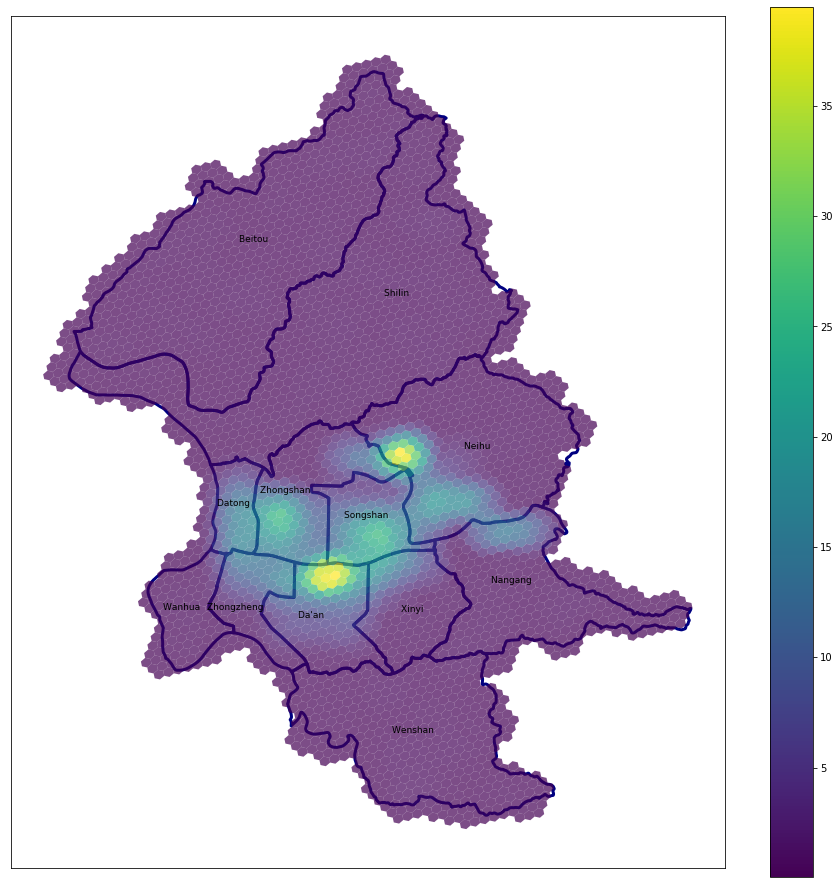

In [153]:
print('sum sanity check:', gdf_ks['cnt'].sum() / gdf_hex['cnt'].sum())
plot_hex(gdf_ks, metric_col='cnt', alpha=0.7)

In [88]:
dense_lat,dense_lng = gdf_hex.iloc[np.argmax(gdf_hex["cnt"])]["lat"],  gdf_hex.iloc[np.argmax(gdf_hex["cnt"])]["lng"]
dense_geo = gdf_hex.iloc[np.argmax(gdf_hex["cnt"])]["geometry"]
dense_geo.exterior.xy

(array('d', [121.545071887787, 121.54472166208598, 121.54293365883174, 121.54149590843478, 121.54184613126168, 121.54363410736025, 121.545071887787]),
 array('d', [25.039771232588677, 25.04138816624878, 25.041778856909424, 25.04055263834434, 25.038935719187933, 25.038545004092402, 25.039771232588677]))

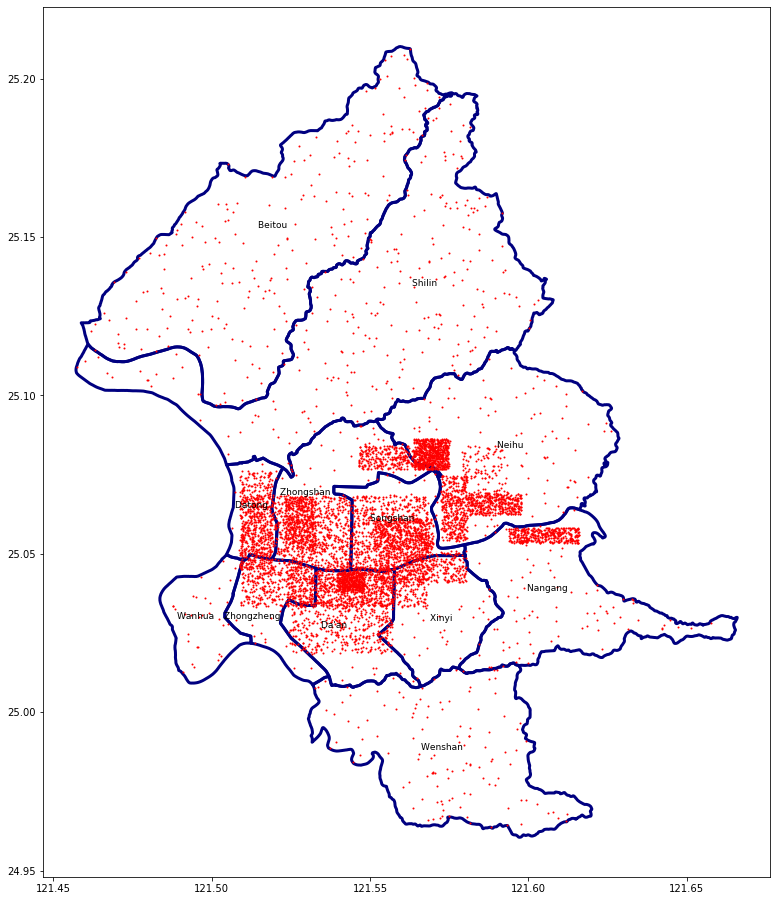

In [156]:
fig, ax = plt.subplots(1, figsize=(16,16))
TPE.plot(ax=ax, facecolor="none", edgecolor="navy", lw=3)
for idx, row in TPE.iterrows():
    plt.annotate(s=row['TOWNENG'], xy=row['coords'], horizontalalignment='center', color='black', fontsize=9)
gdf.plot(ax=ax, markersize=1, c="r")
x,y = dense_geo.exterior.xy
# ax.plot(x,y)
dx = 0.01
dy = 0.01
# plt.ylim([dense_lat - dx, dense_lat + dx])
# plt.xlim([dense_lng - dy, dense_lng + dy])

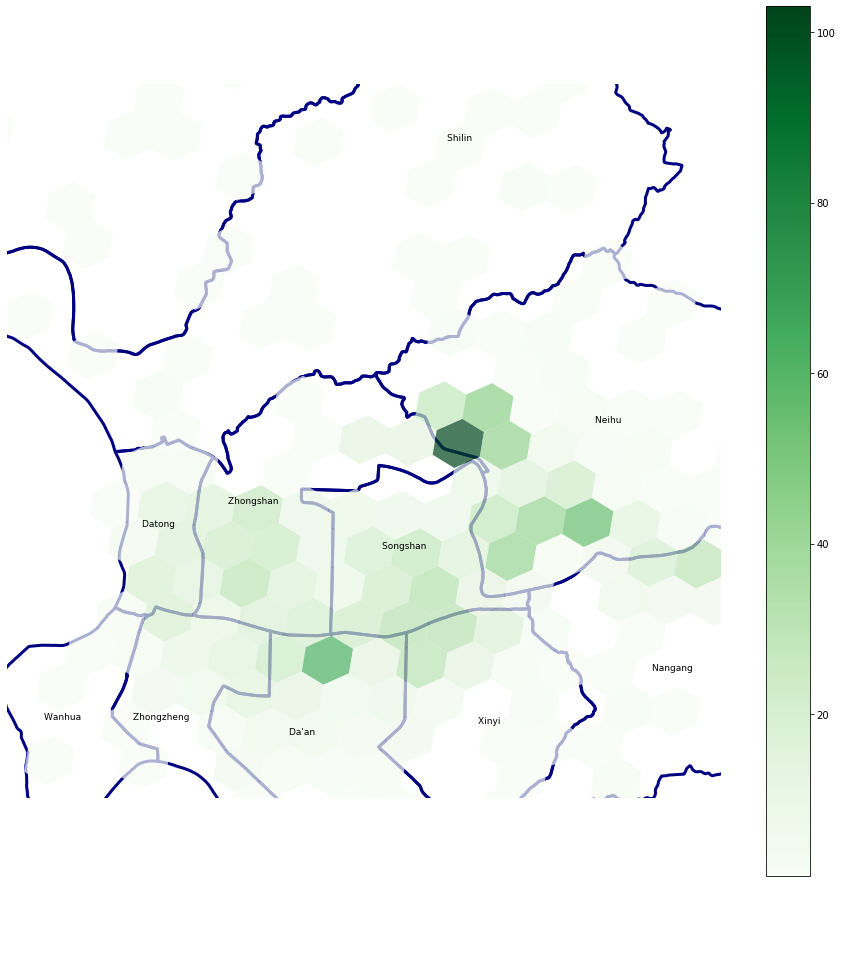

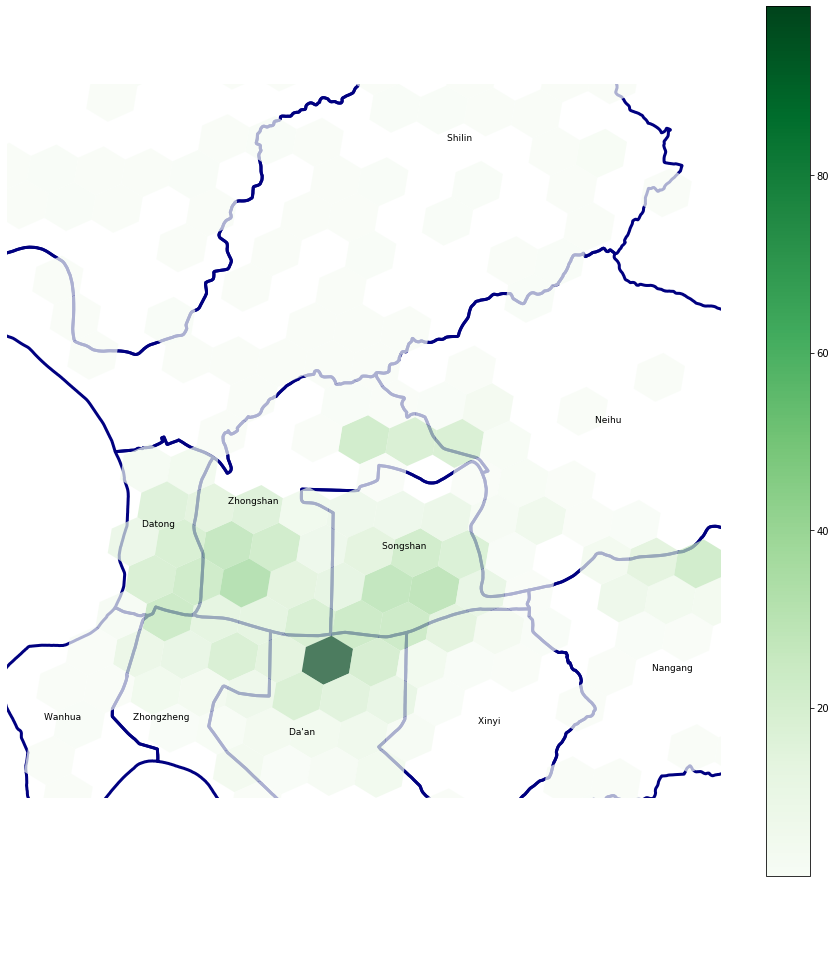

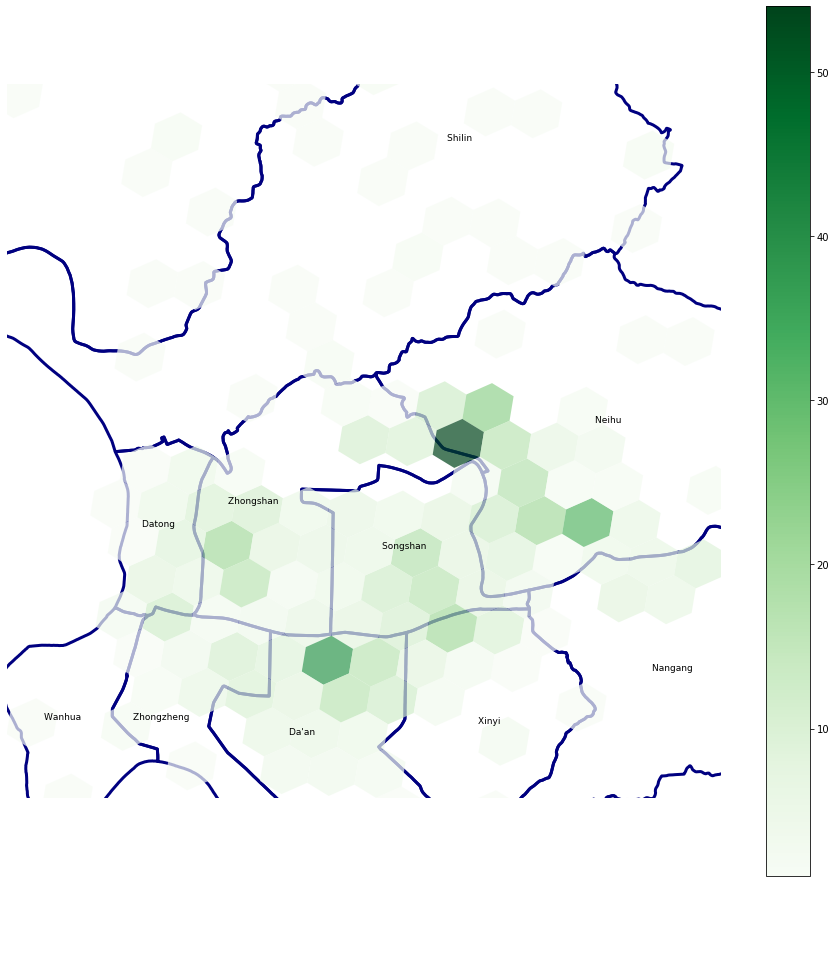

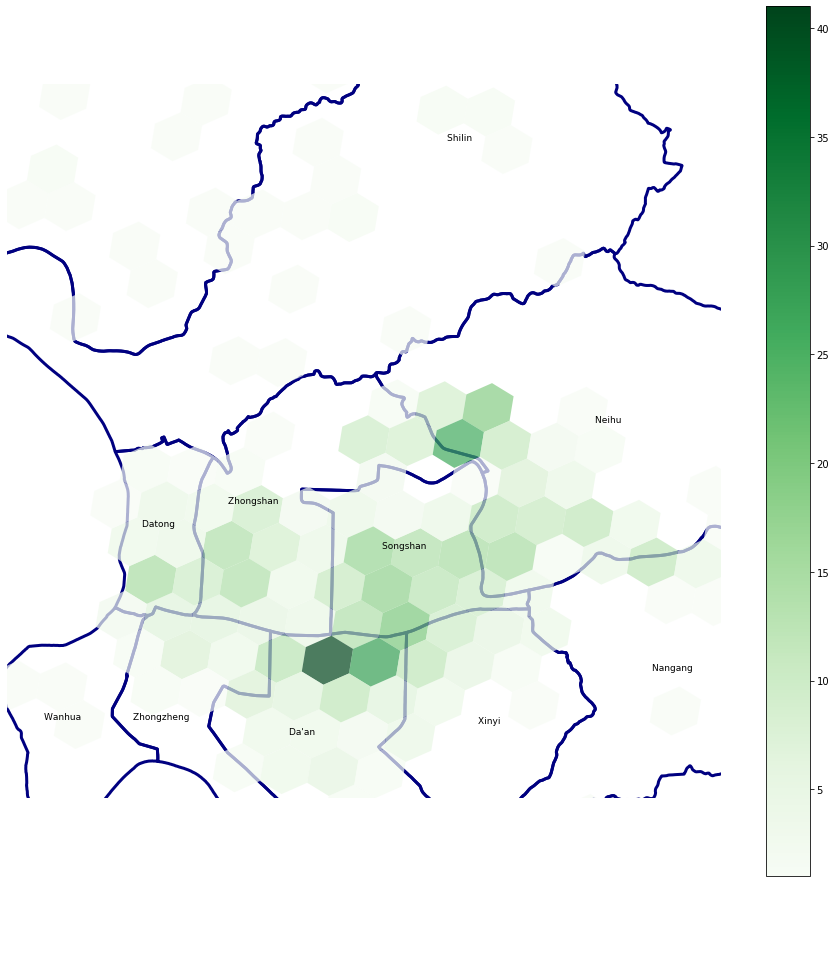

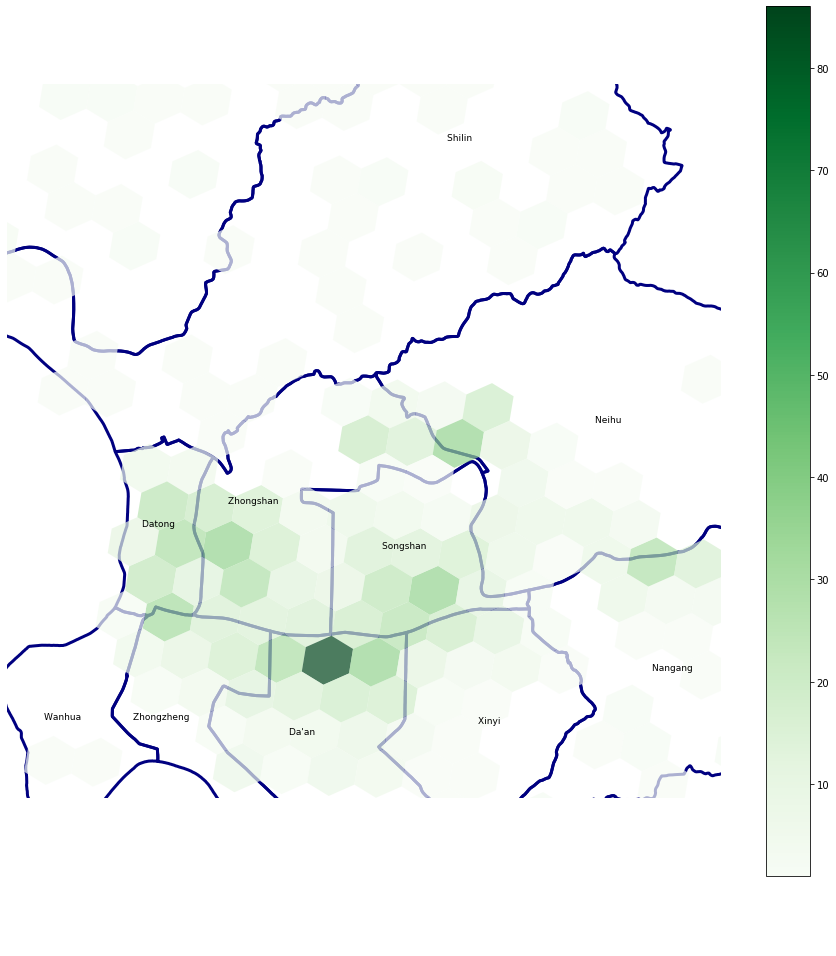

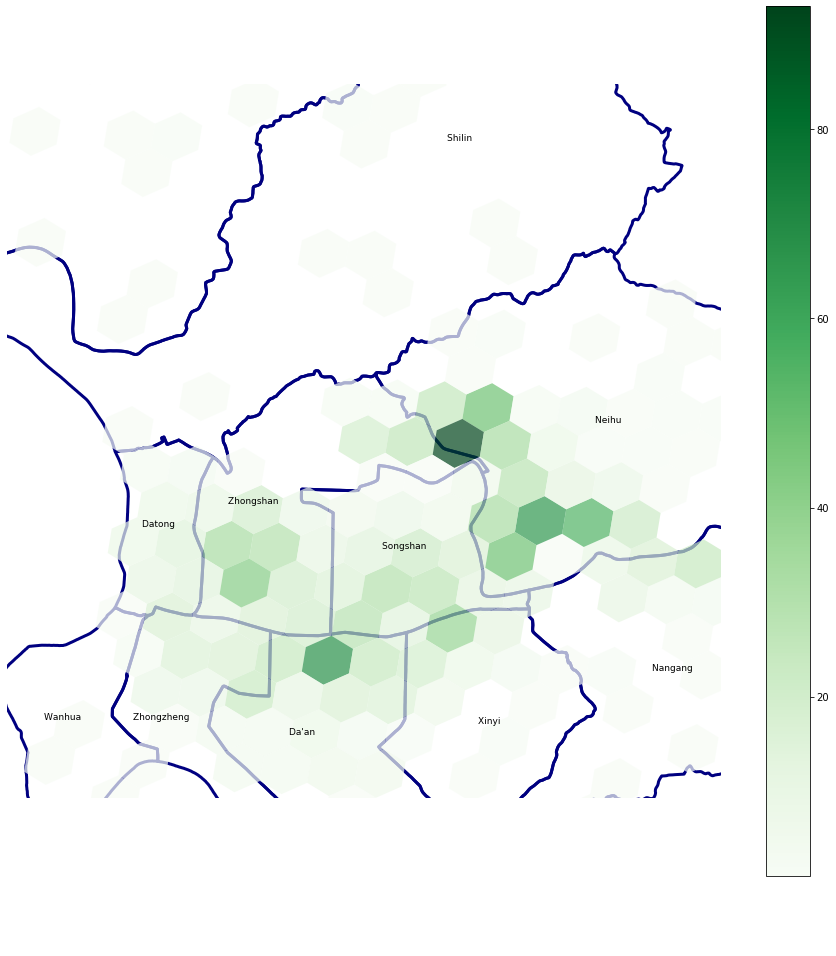

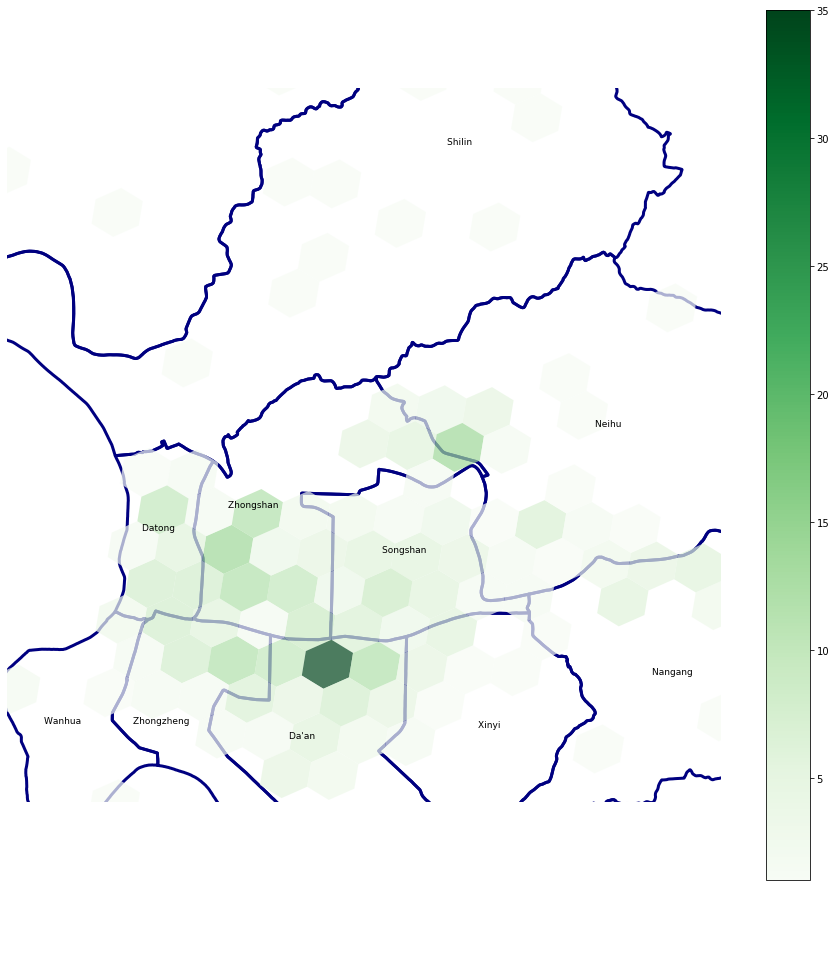

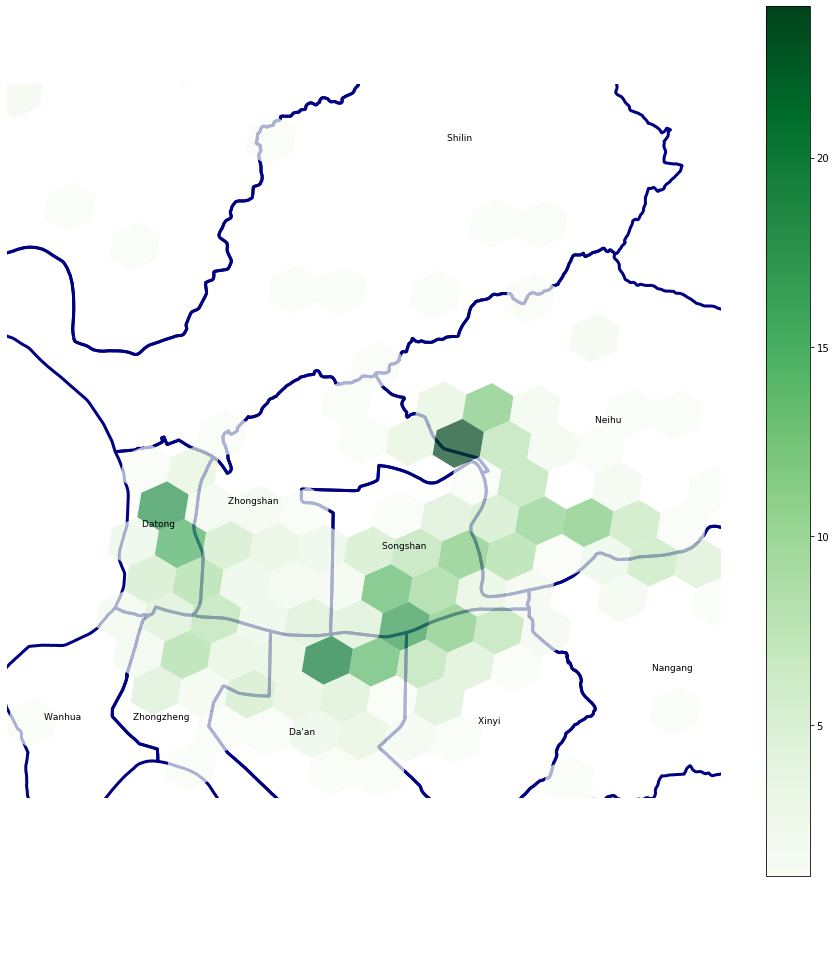

In [76]:
time_definition = ["上班","下午","下班","夜晚"]
DATA_PATH = './timeData_0304.p'
def plot_hex(df, metric_col, name="default", alpha=1, figsize=(16,16), colormap='Reds'):    
    fig, ax = plt.subplots(1,figsize=figsize)
    TPE.plot(ax=ax, facecolor="none", edgecolor="navy", lw=3)
    for idx, row in TPE.iterrows():
        plt.annotate(s=row['TOWNENG'], xy=row['coords'], horizontalalignment='center', color='black', fontsize=9)
    df.plot(ax=ax, column=metric_col, colormap=colormap, alpha=alpha, legend=True)
    plt.xticks([], []); plt.yticks([], [])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    dx, dy = 0.065, 0.065
    plt.xlim(121.55 - dx, 121.55 + dx)
    plt.ylim(25.08 - dy,25.08 + dy)
    fig.savefig(f"../../plots/{name}.png")

def flip(x, y):
    return y, x

def create_plots(datapath, level):
    from shapely.ops import transform
    from shapely.geometry import Polygon
    #parse data
    import pickle
    with open(datapath, 'rb') as f:
         GDF_DICT = pickle.load(f)
    
    hex_col = 'hex'+str(level)
    for i in range(4):
        for j in ["OFF","ON"]:
            df = GDF_DICT[(i,j)]
            df_hex = get_hex(df, level)
            polys = []
            for h in df_hex[hex_col]:
                polygons = h3.h3_set_to_multi_polygon([h], geo_json=False)
                # flatten polygons into loops.
                outlines = [loop for polygon in polygons for loop in polygon]
                polyline = [outline + [outline[0]] for outline in outlines][0]
                polygon = transform(flip,Polygon(polygons[0][0]))
                polys.append(polygon)
            df_hex = gpd.GeoDataFrame(df_hex, geometry = polys)
            plot_hex(df_hex, name = time_definition[i]+f"_{j}", metric_col='cnt',alpha=0.7, colormap="Greens")
            
create_plots(DATA_PATH, 8)

In [63]:
!pwd

/Users/clarence/PycharmProjects/pythonProject/h3-py-notebooks/notebooks


In [79]:
with open(DATA_PATH, 'rb') as f:
    GDF_DICT = pickle.load(f)
for key in GDF_DICT.keys():
    print(key,len(GDF_DICT[key]))

(0, 'OFF') 1595
(0, 'ON') 1400
(1, 'OFF') 832
(1, 'ON') 748
(2, 'OFF') 1361
(2, 'ON') 1613
(3, 'OFF') 457
(3, 'ON') 494
